In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import fftpack
import japanize_matplotlib


np.random.seed(8931)

In [2]:
def detect_batch_time(x: np.ndarray, y: np.ndarray, range_min: int, range_max: int) -> float:
    y_fft = np.fft.fft(y) # 離散フーリエ変換
    freq_array = np.fft.fftfreq(len(x), d=1)
    amp_array = abs(y_fft/(len(x)/2))
    freq_array = freq_array[1:int(len(x)/2)]
    amp_array = amp_array[1:int(len(x)/2)]
    
    df = pd.DataFrame([freq_array, amp_array], index=['FREQ', 'AMP']).T
    df['INV_FREQ'] = 1 / df['FREQ']
    df = df[(range_min <= df['INV_FREQ']) & (df['INV_FREQ'] <= range_max)]
    amp_max_index = df['AMP'].argmax()

    plt.figure(figsize=(6, 2))
    sns.lineplot(df, x='INV_FREQ', y='AMP')
    sns.scatterplot(df, x='INV_FREQ', y='AMP')
    plt.xlim(0, 1500)
    plt.grid(axis='x')
    plt.show()
    
    return df.iloc[amp_max_index]['INV_FREQ']

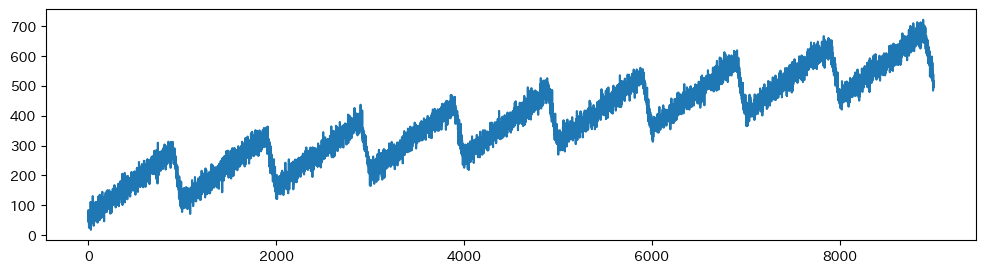

In [3]:
x = np.arange(0, 9000, 1)

trands = np.array([xx * 0.05 + 60 for xx in x])
noises = np.random.normal(0, 20, len(x))

season = []
gain = 0.2

for _ in range(9):
    for idx in range(1000):
        if idx == 0:
            season.append(0)
        elif idx < 900:
            season.append(season[idx - 1] + gain)
        else:
            season.append(season[idx - 1] - 9 * gain)

y = trands + noises + season

plt.figure(figsize=(12, 3))
sns.lineplot(x=x, y=y)
plt.show()

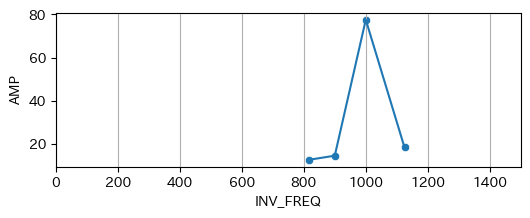

batch_time:  1000.0 [sec]


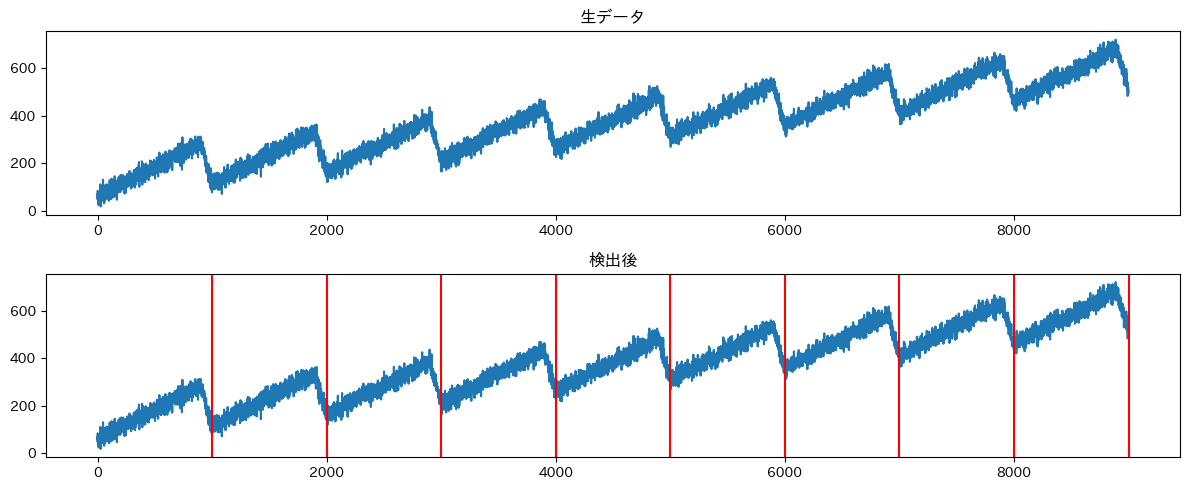

In [4]:
batch_time = detect_batch_time(x=x, y=y, range_min=800, range_max=1200)
print('batch_time: ', batch_time, '[sec]')

plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
sns.lineplot(x=x, y=y)
plt.title('生データ')

plt.subplot(2, 1, 2)
sns.lineplot(x=x, y=y)
plt.title('検出後')

batch_num = 9
for batch in range(1, batch_num+1, 1):
    plt.axvline(batch * batch_time, color='red')



plt.tight_layout()
plt.show()

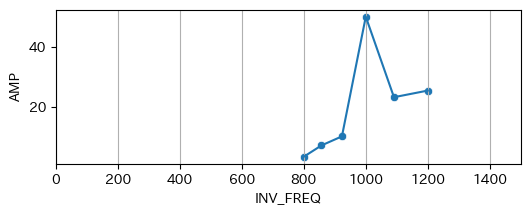

batch_time:  1000.0 [sec]


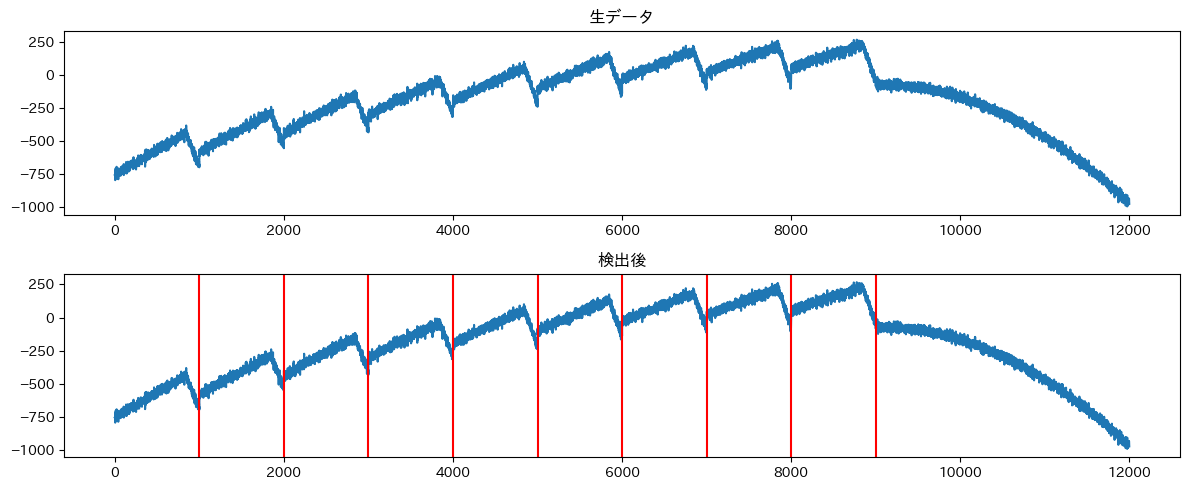

In [5]:
x = np.arange(0, 9000, 1)

trands = np.array([xx * xx * -0.00001 + xx * 0.0005 + 60 for xx in np.arange(-9000, 0, 1)])
noises = np.random.normal(0, 20, len(x))

season = []
gain = 0.2

for _ in range(9):
    thres = np.random.randint(800, 980)
    for idx in range(1000):
        if idx == 0:
            season.append(0)
        elif idx < thres:
            season.append(season[idx - 1] + gain)
        else:
            season.append(season[idx - 1] - 9 * gain)

y = trands + noises + season
x = np.append(x, np.arange(x[-1], x[-1] + 3000, 1))
y = np.append(y, np.array([xx * xx * -0.0001 + xx * 0.00005 + y[-1] for xx in np.arange(0, 3000, 1)]) + np.random.normal(0, 20, 3000))

batch_time = detect_batch_time(x=x, y=y, range_min=800, range_max=1200)
print('batch_time: ', batch_time, '[sec]')

plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
sns.lineplot(x=x, y=y)
plt.title('生データ')

plt.subplot(2, 1, 2)
sns.lineplot(x=x, y=y)
plt.title('検出後')

batch_num = 9
for batch in range(1, batch_num+1, 1):
    plt.axvline(batch * batch_time, color='red')



plt.tight_layout()
plt.show()

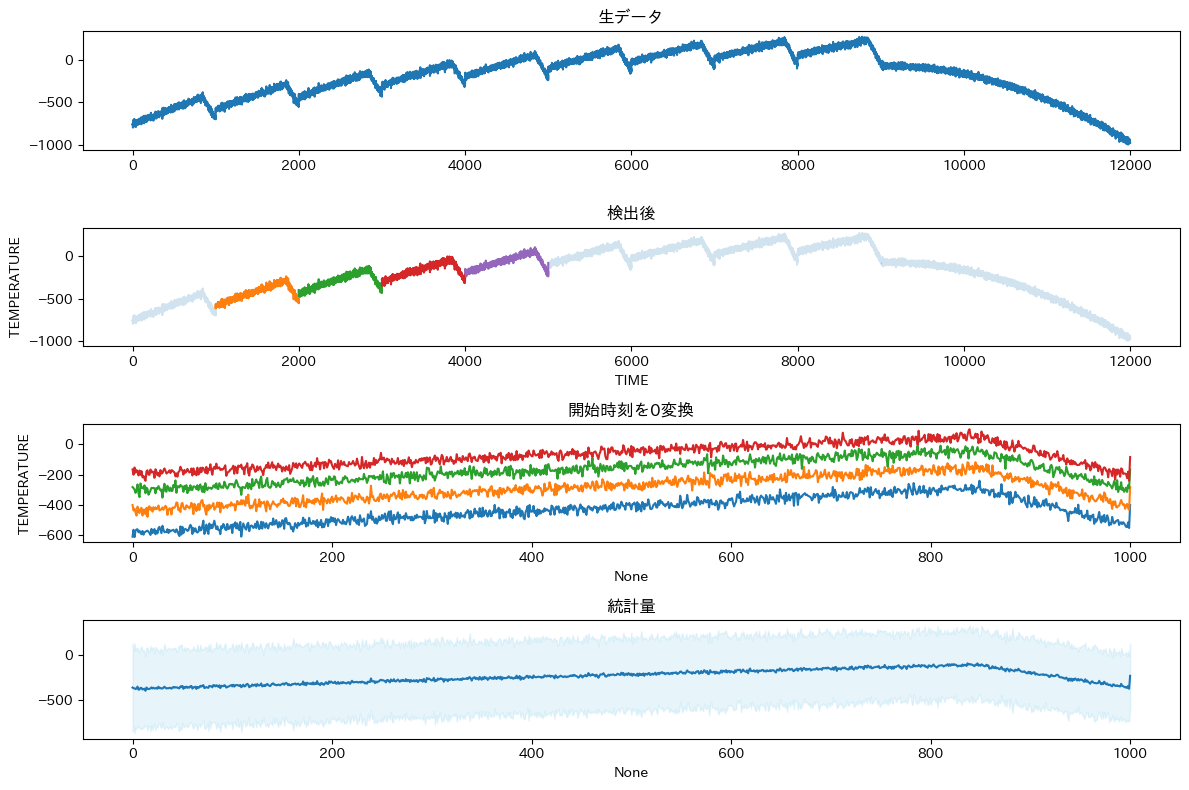

In [6]:
class SpatterTemperatureSplitter:
    def execute(self, x: np.ndarray, y: np.ndarray, total_batch_num: int, target_batch: list[int], batch_time_min: int, batch_time_max: int) -> pd.DataFrame:
        """
            Note:
                スパッタデータをFFTを用いてバッチ単位に分割する。
            Args:
                x               :np.ndarray 時刻データ
                y               :np.ndarray 温度データ
                total_batch_num :int        データに含まれるバッチ数(空飛ばし含む)
                target_batch    :list[int]  抽出するバッチ番号(空飛ばしを0とする)
                batch_time_min  :int        想定される1バッチ時間のmin値
                batch_time_max  :int        想定される1バッチ時間のmax値
                
        """
        batch_time = int(self._detect_batch_time(x=x, y=y, range_min=batch_time_min, range_max=batch_time_max))

        df = None
        
        for batch_no in range(total_batch_num + 1):
            if batch_no not in target_batch: continue
            range_min = batch_time * batch_no
            range_max = batch_time * batch_no + batch_time

            df_temperature = pd.DataFrame(data=[x, y], index=['TIME', 'TEMPERATURE']).T
            df_temperature = df_temperature[(range_min <= df_temperature['TIME']) & (df_temperature['TIME'] <= range_max)]
            df_temperature['BATCH_NO'] = batch_no

            if df is None:
                df = df_temperature
            else:
                df = pd.concat([df, df_temperature])
        return df
    

    def _detect_batch_time(self, x: np.ndarray, y: np.ndarray, range_min: int, range_max: int) -> float:
        y_fft = np.fft.fft(y) # 離散フーリエ変換
        freq_array = np.fft.fftfreq(len(x), d=1)
        amp_array = abs(y_fft/(len(x)/2))
        freq_array = freq_array[1:int(len(x)/2)]
        amp_array = amp_array[1:int(len(x)/2)]
        
        df = pd.DataFrame([freq_array, amp_array], index=['FREQ', 'AMP']).T
        df['INV_FREQ'] = 1 / df['FREQ']
        df = df[(range_min <= df['INV_FREQ']) & (df['INV_FREQ'] < range_max)]
        amp_max_index = df['AMP'].argmax()
    
        # plt.figure(figsize=(6, 2))
        # sns.lineplot(df, x='INV_FREQ', y='AMP')
        # sns.scatterplot(df, x='INV_FREQ', y='AMP')
        # plt.xlim(0, 1500)
        # plt.grid(axis='x')
        # plt.show()
        
        return df.iloc[amp_max_index]['INV_FREQ']

df = SpatterTemperatureSplitter().execute(x, y, 9, [1, 2, 3, 4], 900, 1100)

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
sns.lineplot(x=x, y=y)
plt.title('生データ')

plt.subplot(4, 1, 2)
sns.lineplot(x=x, y=y, alpha=0.2)
for batch_no in df['BATCH_NO'].unique():
    sns.lineplot(df[df['BATCH_NO'] == batch_no], x='TIME', y='TEMPERATURE')
plt.title('検出後')

plt.subplot(4, 1, 3)
for batch_no in df['BATCH_NO'].unique():
    df_one = df[df['BATCH_NO'] == batch_no]
    df_one = df_one.reset_index()
    sns.lineplot(df_one, x=df_one.index, y='TEMPERATURE')
plt.title('開始時刻を0変換')

plt.subplot(4, 1, 4)
std_x = None
std_y = []

for batch_no in df['BATCH_NO'].unique():
    df_one = df[df['BATCH_NO'] == batch_no]
    df_one = df_one.reset_index()
    std_x=df_one.index
    std_y.append(df_one['TEMPERATURE'].values.tolist())

y_mean = np.array(std_y).mean(axis=0)
y_std = np.array(std_y).std(axis=0)
sns.lineplot(x=std_x, y=y_mean)
plt.fill_between(std_x, y_mean - 3 * y_std, y_mean + 3 * y_std, color='skyblue', alpha=0.2)
plt.title('統計量')


plt.tight_layout()
plt.show()